In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from collections import defaultdict
from sklearn.neural_network import MLPClassifier 

from sklearn import model_selection, ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold

# model saving
import pickle 
from joblib import Parallel, delayed
import joblib

# heatmap
import seaborn as sn

from matplotlib import pyplot

In [4]:
! pip install gdown

In [5]:
!gdown 1BQ_5BnEJfpR0a4K1GJB99RVR2Q63eXIF

Downloading...
From: https://drive.google.com/uc?id=1BQ_5BnEJfpR0a4K1GJB99RVR2Q63eXIF
To: /kaggle/working/tumor_gene_Symbol_dataset.csv
100%|███████████████████████████████████████| 1.38G/1.38G [00:08<00:00, 166MB/s]


# data process

In [6]:
gene_symbol_mapping= pd.read_csv("./tumor_gene_Symbol_dataset.csv", sep=',')
gene_symbol_mapping = gene_symbol_mapping.sort_values(by=['Unnamed: 0'])
gene_symbol_mapping= gene_symbol_mapping.set_index('Unnamed: 0')
gene_symbol_mapping = gene_symbol_mapping[gene_symbol_mapping['cancer type abbreviation'].notna()]

gene_symbol_mapping

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658,GBM,78.0,MALE,WHITE
TCGA-02-0055-01,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658,GBM,62.0,FEMALE,WHITE
TCGA-02-2483-01,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658,GBM,43.0,MALE,ASIAN
TCGA-02-2485-01,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658,GBM,53.0,MALE,BLACK OR AFRICAN AMERICAN
TCGA-04-1331-01,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658,OV,78.0,FEMALE,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CF-02,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,LIHC,64.0,MALE,WHITE
TCGA-ZS-A9CG-01,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,LIHC,55.0,MALE,WHITE
TCGA-ZT-A8OM-01,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,THYM,73.0,FEMALE,WHITE


In [7]:
cancer_names= gene_symbol_mapping['cancer type abbreviation'].unique()

In [8]:
gene_symbol_mapping['age_at_initial_pathologic_diagnosis']= gene_symbol_mapping['age_at_initial_pathologic_diagnosis'].astype(str)

d = defaultdict(LabelEncoder)
columns_to_encode = [
    "cancer type abbreviation",
    "age_at_initial_pathologic_diagnosis",
    "gender",
    "race"
]

gene_symbol_mapping.loc[:,columns_to_encode] = gene_symbol_mapping.loc[:,columns_to_encode].apply(lambda x: d[x.name].fit_transform(x.fillna('0')))
gene_symbol_mapping.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9784 entries, TCGA-02-0047-01 to TCGA-ZX-AA5X-01
Columns: 19242 entries, RAB4B to race
dtypes: float64(19238), int64(4)
memory usage: 1.4+ GB


In [9]:
columns_to_drop = [
    "cancer type abbreviation",
    "age_at_initial_pathologic_diagnosis",
    "gender",
    "race"
]
# X = gene_symbol_mapping_dummies.drop(['cancer type abbreviation'], axis=1).copy()


In [10]:
cancer_nums= gene_symbol_mapping['cancer type abbreviation'].unique()
cancer_name_num_dict = dict(zip(cancer_nums, cancer_names))
cancer_name_num_dict

{8: 'GBM',
 19: 'OV',
 16: 'LUAD',
 17: 'LUSC',
 22: 'PRAD',
 30: 'UCEC',
 1: 'BLCA',
 27: 'TGCT',
 7: 'ESCA',
 20: 'PAAD',
 12: 'KIRP',
 15: 'LIHC',
 3: 'CESC',
 24: 'SARC',
 2: 'BRCA',
 29: 'THYM',
 18: 'MESO',
 5: 'COAD',
 26: 'STAD',
 25: 'SKCM',
 4: 'CHOL',
 11: 'KIRC',
 28: 'THCA',
 9: 'HNSC',
 13: 'LAML',
 23: 'READ',
 14: 'LGG',
 6: 'DLBC',
 10: 'KICH',
 31: 'UCS',
 0: 'ACC',
 21: 'PCPG',
 32: 'UVM'}

In [11]:
gene_symbol_mapping_dummies = gene_symbol_mapping.copy()
gene_symbol_mapping_dummies = pd.get_dummies(gene_symbol_mapping_dummies)

X = gene_symbol_mapping_dummies.drop(columns_to_drop, axis=1).copy()
y = gene_symbol_mapping_dummies['cancer type abbreviation'].copy()
X

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,ARHGAP21,DDX47,POMZP3,EIF5B,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,5.0343,4.7767,2.8117,4.2929,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658
TCGA-02-0055-01,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,3.3966,5.0304,2.9802,4.6000,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658
TCGA-02-2483-01,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,4.2973,5.4087,5.4423,5.0099,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658
TCGA-02-2485-01,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,4.8630,5.0837,5.0549,4.7269,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658
TCGA-04-1331-01,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,3.3717,4.6927,4.3177,5.3646,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CF-02,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,2.3479,3.8680,1.7660,3.6066,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658
TCGA-ZS-A9CG-01,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,1.7786,3.6816,0.8568,3.1327,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658
TCGA-ZT-A8OM-01,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,1.5514,4.4621,5.9704,3.9041,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658


In [9]:
# mlpc_params = {"alpha": [0.0001,0.001],
              # "learning_rate_init":[0.0001,0.001]}

In [10]:
# mlpc = MLPClassifier(alpha=0.001,learning_rate_init=0.001 , random_state = 42,activation="relu", hidden_layer_sizes=(100,100,100),early_stopping=True,validation_fraction=0.2,solver='adam',max_iter=200, verbose=True) 

# mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, cv = 5, verbose = 2)
# mlpc_cv_model.fit(X,y) 

In [11]:
# print("The best parameters: " + str(mlpc_cv_model.best_params_))


# load the datasets

In [12]:
!gdown 15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP

Downloading...
From: https://drive.google.com/uc?id=15sUdoFB8qTwcsGyPky2CmDwmRi5f5KZP
To: /kaggle/working/data.zip
100%|███████████████████████████████████████| 2.42G/2.42G [00:17<00:00, 141MB/s]


In [13]:
!unzip ./data.zip

Archive:  ./data.zip
  inflating: test_split_1.csv        
  inflating: test_split_2.csv        
  inflating: test_split_3.csv        
  inflating: test_split_4.csv        
  inflating: test_split_5.csv        
  inflating: train_split_1.csv       
  inflating: train_split_2.csv       
  inflating: train_split_3.csv       
  inflating: train_split_4.csv       
  inflating: train_split_5.csv       


In [14]:
# from google.colab import drive
# drive.mount('./gdrive')

# 1

In [14]:
test_split_1= pd.read_csv("./test_split_1.csv", sep=',')
test_split_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658,8,64,1,5
1,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658,8,48,0,5
2,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658,8,29,1,2
3,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658,8,39,1,3
4,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658,19,64,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,4.9878,3.2915,3.6939,-4.0350,10.2184,4.4437,-6.5064,-5.0116,-9.9658,0.1648,...,1.5064,-9.9658,-4.0350,1.5854,4.9132,-9.9658,32,64,1,5
1953,5.5420,2.5213,3.8993,-5.5735,10.2946,4.6600,-9.9658,-4.0350,-2.6349,-0.8339,...,2.1147,-9.9658,-9.9658,-1.6394,5.3548,-9.9658,32,24,1,5
1954,4.9050,1.4441,3.9506,-9.9658,10.2031,5.0282,-9.9658,-3.6259,-2.8262,1.1117,...,2.2513,-9.9658,-6.5064,-0.2845,5.0618,-9.9658,32,23,0,5
1955,5.5305,3.3148,3.4752,-3.1714,10.2961,4.1828,-1.2142,-5.5735,-6.5064,0.1519,...,1.6234,-9.9658,-5.5735,2.0946,4.9778,-9.9658,32,46,1,5


In [15]:
test_split_1_dummies = test_split_1.copy()
test_split_1_dummies = pd.get_dummies(test_split_1_dummies)

X_test_1 = test_split_1_dummies.drop(columns_to_drop, axis=1).copy()
y_test_1 = test_split_1_dummies['cancer type abbreviation'].copy()

X_test_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,ARHGAP21,DDX47,POMZP3,EIF5B,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4
0,5.2698,3.0270,3.8876,-9.9658,9.0048,5.5361,1.1960,-2.3147,-2.2447,1.9452,...,5.0343,4.7767,2.8117,4.2929,2.2113,-1.3183,-0.4325,3.2143,4.6247,-9.9658
1,4.9026,2.9243,3.0498,-5.5735,10.4794,5.5877,1.8363,-0.2671,-0.1504,0.0014,...,3.3966,5.0304,2.9802,4.6000,1.8996,-5.0116,-1.3548,4.1716,4.2563,-9.9658
2,5.1260,2.8076,3.5754,-9.9658,10.5954,4.8500,0.5069,-0.6643,-4.6082,2.6940,...,4.2973,5.4087,5.4423,5.0099,0.0580,-9.9658,-4.6082,2.1988,4.2412,-9.9658
3,5.9409,3.5224,3.9746,-6.5064,9.8786,5.4383,0.2522,-0.9686,-1.5522,2.8158,...,4.8630,5.0837,5.0549,4.7269,1.1184,-5.5735,1.1250,3.0791,4.7132,-9.9658
4,4.7005,1.3567,5.1639,-1.1811,8.7960,3.7400,2.5137,3.0706,-0.7108,0.9115,...,3.3717,4.6927,4.3177,5.3646,2.3394,-5.5735,-4.2934,0.9642,4.8218,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,4.9878,3.2915,3.6939,-4.0350,10.2184,4.4437,-6.5064,-5.0116,-9.9658,0.1648,...,1.9675,4.8555,2.0742,4.8012,1.5064,-9.9658,-4.0350,1.5854,4.9132,-9.9658
1953,5.5420,2.5213,3.8993,-5.5735,10.2946,4.6600,-9.9658,-4.0350,-2.6349,-0.8339,...,2.1247,4.4390,2.7636,3.1129,2.1147,-9.9658,-9.9658,-1.6394,5.3548,-9.9658
1954,4.9050,1.4441,3.9506,-9.9658,10.2031,5.0282,-9.9658,-3.6259,-2.8262,1.1117,...,2.6418,4.6708,3.1523,4.8660,2.2513,-9.9658,-6.5064,-0.2845,5.0618,-9.9658
1955,5.5305,3.3148,3.4752,-3.1714,10.2961,4.1828,-1.2142,-5.5735,-6.5064,0.1519,...,2.2237,4.6871,4.0037,4.7431,1.6234,-9.9658,-5.5735,2.0946,4.9778,-9.9658


In [16]:
train_split_1= pd.read_csv("./train_split_1.csv", sep=',')
train_split_1

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.4680,3.5694,4.2126,-2.4659,9.0496,5.3636,0.6608,-0.6873,-2.6349,2.0946,...,1.0151,-3.6259,0.8805,4.2578,4.9308,-9.9658,8,46,1,5
1,5.4787,2.7422,3.7571,-1.8836,9.6983,5.7642,0.1903,-0.3022,-1.3921,1.8604,...,1.7702,-2.6349,0.8408,1.1512,4.2103,-9.9658,8,59,0,3
2,5.6994,3.0481,4.1094,-9.9658,9.9318,5.3155,1.8323,0.4967,-2.2447,1.3109,...,0.4967,-9.9658,-0.2498,3.5111,4.7587,-9.9658,8,39,1,5
3,6.2196,2.4985,3.8551,-3.4580,9.6547,5.2114,-2.3884,-1.8836,-1.5522,1.5366,...,1.9111,-2.6349,0.1124,3.3979,4.4784,-9.9658,8,55,1,5
4,6.0540,2.3760,3.6972,-6.5064,10.0772,4.8783,0.3231,0.7321,-2.5479,1.9527,...,0.2881,-9.9658,-0.1031,4.0926,4.6306,-9.9658,8,52,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7822,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,15,50,1,5
7823,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,15,41,1,5
7824,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,29,59,0,5
7825,5.0631,2.9784,3.5212,-5.5735,9.6838,5.0466,1.3956,-2.1140,-1.4699,0.3231,...,1.4704,-0.1031,-5.5735,2.4386,4.8530,-9.9658,4,38,1,5


In [17]:
train_split_1_dummies = train_split_1.copy()
train_split_1_dummies = pd.get_dummies(train_split_1_dummies)

X_train_1 = train_split_1_dummies.drop(columns_to_drop, axis=1).copy()
y_train_1 = train_split_1_dummies['cancer type abbreviation'].copy()

In [19]:
# X_train1=X_train_1.copy()
# y_train1=y_train_1.copy()

In [20]:
# X_train_1,X_valid_1,y_train_1 , y_valid_1  = train_test_split(X_train1,y_train1, test_size=0.2, random_state = 42, stratify=y_train_1)

In [18]:
# eval_set = [(X_train_1, y_train_1), (X_valid_1, y_valid_1)]

mlpc_1 = MLPClassifier(alpha=0.001,learning_rate_init=0.001 , random_state = 42,activation="relu", hidden_layer_sizes=(100,100,100),early_stopping=True,validation_fraction=0.2,solver='adam',max_iter=200, verbose=True) 

# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
mlpc_1.fit(X_train_1, y_train_1)
 

Iteration 1, loss = 10.33821736


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.579821
Iteration 2, loss = 0.76444197


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.879310
Iteration 3, loss = 0.34495039


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.906130
Iteration 4, loss = 0.24804087


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.913155
Iteration 5, loss = 0.21625245


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.913793
Iteration 6, loss = 0.17648178


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943167
Iteration 7, loss = 0.13076995


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.928480
Iteration 8, loss = 0.11410260


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.925287
Iteration 9, loss = 0.10273529


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943167
Iteration 10, loss = 0.09481912


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943806
Iteration 11, loss = 0.06724185


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.945083
Iteration 12, loss = 0.05974621


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948914
Iteration 13, loss = 0.05162111


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.932950
Iteration 14, loss = 0.04695083


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.939974
Iteration 15, loss = 0.04353318


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.927203
Iteration 16, loss = 0.03744605


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948914
Iteration 17, loss = 0.03076635


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.950192
Iteration 18, loss = 0.02648855


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.952107
Iteration 19, loss = 0.02166355


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955939
Iteration 20, loss = 0.02401471


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943167
Iteration 21, loss = 0.02083180


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.945722
Iteration 22, loss = 0.04296266


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.922095
Iteration 23, loss = 0.04551400


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.941890
Iteration 24, loss = 0.02384409


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948914
Iteration 25, loss = 0.01274953


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.950830
Iteration 26, loss = 0.01306177


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.949553
Iteration 27, loss = 0.02163087


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955300
Iteration 28, loss = 0.00695010


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 29, loss = 0.00503637


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 30, loss = 0.00468755


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.958493
Iteration 31, loss = 0.00460135


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955300
Iteration 32, loss = 0.00674000


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.958493
Iteration 33, loss = 0.01366704


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.951469
Iteration 34, loss = 0.02832007


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955300
Iteration 35, loss = 0.01665338


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955939
Iteration 36, loss = 0.00441941


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.960409
Iteration 37, loss = 0.00308730


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 38, loss = 0.00278161


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 39, loss = 0.00266422


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955939
Iteration 40, loss = 0.00255829


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.961686
Iteration 41, loss = 0.00249225


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 42, loss = 0.00239014


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.958493
Iteration 43, loss = 0.00232188


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959132
Iteration 44, loss = 0.00226353


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.960409
Iteration 45, loss = 0.00228789


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.958493
Iteration 46, loss = 0.00215047


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.960409
Iteration 47, loss = 0.00209684


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.961686
Iteration 48, loss = 0.00209303


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.961686
Iteration 49, loss = 0.00209020


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.960409
Iteration 50, loss = 0.00201882


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.960409
Iteration 51, loss = 0.00201283


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(100, 100, 100), random_state=42,
              validation_fraction=0.2, verbose=True)

In [19]:
# Save the model as a pickle in a file
joblib.dump(mlpc_1, 'tumor_mlp_model_sort_1')
  
# Load the model from the file
mlp1_model_from_joblib = joblib.load('tumor_mlp_model_sort_1')

In [20]:
y_pred_1 = mlp1_model_from_joblib.predict(X_test_1)

cm1=(confusion_matrix(y_test_1, y_pred_1))

In [21]:
def plot_conf_matrix(cm, y_test):
    labels=y_test.unique()
    cancer_names=[]
    for i in labels:
        if i in cancer_name_num_dict.keys():
            cancer_names.append(cancer_name_num_dict[i])
    
    column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
    indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]
    
    table= pd.DataFrame(cm, columns=column, index=indices)
    
    fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

    return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

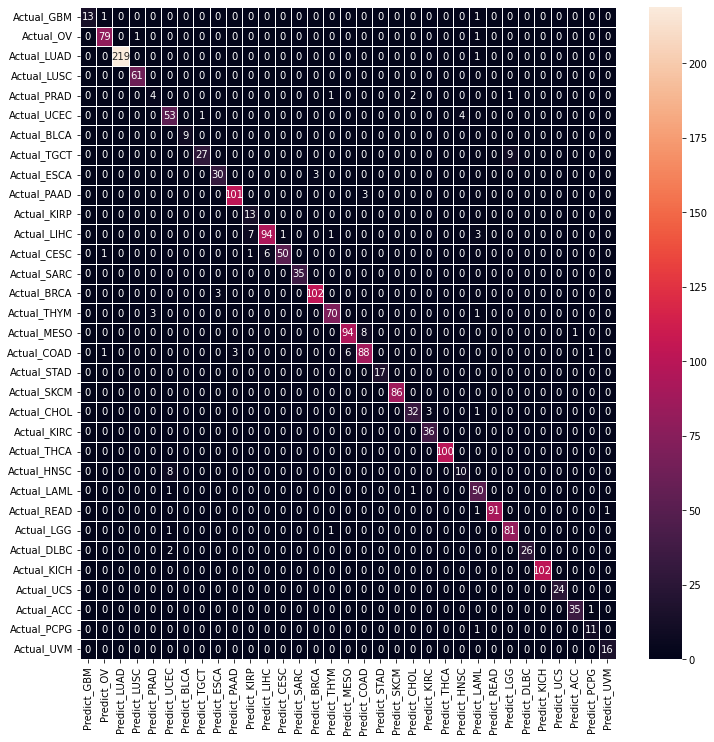

In [22]:
plot_conf_matrix(cm1,y_test_1)

In [24]:
# make predictions for test data
predictions_1 = [round(value) for value in y_pred_1]
# evaluate predictions
accuracy_1 = accuracy_score(y_test_1, predictions_1)
print("Accuracy: %.2f%%" % (accuracy_1 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_1 = precision_score(y_test_1, predictions_1, average='micro')
print('Precision for all class: %f' % precision_1)

# recall: tp / (tp + fn)
recall_1 = recall_score(y_test_1, predictions_1,average='micro')
print('Recall: %f' % recall_1)
# f1: 2 tp / (2 tp + fp + fn)
f1_1 = f1_score(y_test_1, predictions_1, average='micro')
print('F1 score: %f' % f1_1)

Accuracy: 94.99%
Precision for all class: 0.949923
Recall: 0.949923
F1 score: 0.949923


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_1.pkl' /content/gdrive/MyDrive/gene_seq/

# 2

In [25]:
test_split_2= pd.read_csv("./test_split_2.csv", sep=',')
test_split_2

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,5.4680,3.5694,4.2126,-2.4659,9.0496,5.3636,0.6608,-0.6873,-2.6349,2.0946,...,1.0151,-3.6259,0.8805,4.2578,4.9308,-9.9658,8,46,1,5
1,5.4787,2.7422,3.7571,-1.8836,9.6983,5.7642,0.1903,-0.3022,-1.3921,1.8604,...,1.7702,-2.6349,0.8408,1.1512,4.2103,-9.9658,8,59,0,3
2,5.6994,3.0481,4.1094,-9.9658,9.9318,5.3155,1.8323,0.4967,-2.2447,1.3109,...,0.4967,-9.9658,-0.2498,3.5111,4.7587,-9.9658,8,39,1,5
3,6.2196,2.4985,3.8551,-3.4580,9.6547,5.2114,-2.3884,-1.8836,-1.5522,1.5366,...,1.9111,-2.6349,0.1124,3.3979,4.4784,-9.9658,8,55,1,5
4,6.0540,2.3760,3.6972,-6.5064,10.0772,4.8783,0.3231,0.7321,-2.5479,1.9527,...,0.2881,-9.9658,-0.1031,4.0926,4.6306,-9.9658,8,52,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.7469,1.4547,4.4542,-4.2934,10.9842,4.8997,-2.8262,0.7832,-4.0350,1.4911,...,0.8164,-3.6259,0.2881,1.5115,5.9789,-9.9658,29,27,1,5
1953,6.1196,1.5514,3.9194,-3.8160,11.2873,4.3492,1.6420,0.0580,-0.9971,0.1776,...,-0.3752,-5.5735,-4.2934,3.6759,5.3615,-9.9658,29,51,0,5
1954,6.2782,-0.2159,2.4883,-5.5735,12.1155,3.9534,-2.2447,-1.2481,-4.6082,-0.8084,...,-0.9971,-5.0116,-0.5125,3.6301,6.4278,-9.9658,29,29,1,5
1955,6.5600,0.9935,3.5060,-9.9658,11.8054,4.3456,-2.9324,-1.6394,-9.9658,-0.1345,...,-1.1488,-3.4580,0.2522,3.5742,6.2489,-9.9658,29,12,1,5


In [26]:
test_split_2_dummies = test_split_2.copy()
test_split_2_dummies = pd.get_dummies(test_split_2_dummies)

X_test_2 = test_split_2_dummies.drop(columns_to_drop, axis=1).copy()
y_test_2 = test_split_2_dummies['cancer type abbreviation'].copy()

In [27]:
train_split_2= pd.read_csv("./train_split_2.csv", sep=',')
# train_split_1

In [28]:
train_split_2_dummies = train_split_2.copy()
train_split_2_dummies = pd.get_dummies(train_split_2_dummies)

X_train_2 = train_split_2_dummies.drop(columns_to_drop, axis=1).copy()
y_train_2 = train_split_2_dummies['cancer type abbreviation'].copy()

In [ ]:
# X_train2=X_train_2.copy()
# y_train2=y_train_2.copy()

In [ ]:
# X_train_2,X_valid_2,y_train_2 , y_valid_2  = train_test_split(X_train2,y_train2, test_size=0.2, random_state = 42, stratify=y_train_2)

In [29]:
# eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)]

mlpc_2 = MLPClassifier(alpha=0.001,learning_rate_init=0.001 , random_state = 42,activation="relu", hidden_layer_sizes=(100,100,100),early_stopping=True,validation_fraction=0.2,solver='adam',max_iter=200, verbose=True) 
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
mlpc_2.fit(X_train_2, y_train_2)
 

Iteration 1, loss = 11.82052146


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.587484
Iteration 2, loss = 0.88121335


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.856322
Iteration 3, loss = 0.37098971


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.892720
Iteration 4, loss = 0.28304833


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.906130
Iteration 5, loss = 0.22237006


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.916347
Iteration 6, loss = 0.17620355


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.915709
Iteration 7, loss = 0.12958598


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.921456
Iteration 8, loss = 0.12555100


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.908046
Iteration 9, loss = 0.10753763


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.930396
Iteration 10, loss = 0.08724575


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.921456
Iteration 11, loss = 0.07924066


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.936143
Iteration 12, loss = 0.06157646


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.934227
Iteration 13, loss = 0.04741558


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.924649
Iteration 14, loss = 0.05487903


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938059
Iteration 15, loss = 0.04389206


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.936782
Iteration 16, loss = 0.03270490


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938697
Iteration 17, loss = 0.02471035


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938059
Iteration 18, loss = 0.02887747


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938059
Iteration 19, loss = 0.03492530


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.931034
Iteration 20, loss = 0.03029557


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938059
Iteration 21, loss = 0.02074547


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.939336
Iteration 22, loss = 0.01851181


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943167
Iteration 23, loss = 0.01057832


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943806
Iteration 24, loss = 0.00921062


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943167
Iteration 25, loss = 0.01437861


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.941252
Iteration 26, loss = 0.01017034


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.945083
Iteration 27, loss = 0.01292802


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.942529
Iteration 28, loss = 0.01250808


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.940613
Iteration 29, loss = 0.00608177


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943167
Iteration 30, loss = 0.00528632


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.944444
Iteration 31, loss = 0.00435873


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.941252
Iteration 32, loss = 0.00501415


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943167
Iteration 33, loss = 0.00402521


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.944444
Iteration 34, loss = 0.00337329


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.947637
Iteration 35, loss = 0.00307389


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946999
Iteration 36, loss = 0.00294900


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943806
Iteration 37, loss = 0.00296228


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946360
Iteration 38, loss = 0.00271512


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.947637
Iteration 39, loss = 0.00263932


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.947637
Iteration 40, loss = 0.00257840


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.944444
Iteration 41, loss = 0.00252141


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946360
Iteration 42, loss = 0.00243860


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.947637
Iteration 43, loss = 0.00236511


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948276
Iteration 44, loss = 0.00231495


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948276
Iteration 45, loss = 0.00224739


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948914
Iteration 46, loss = 0.00221437


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946999
Iteration 47, loss = 0.00214518


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946999
Iteration 48, loss = 0.00210806


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946999
Iteration 49, loss = 0.00207174


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948276
Iteration 50, loss = 0.00205351


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948276
Iteration 51, loss = 0.00199833


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.947637
Iteration 52, loss = 0.00194344


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.947637
Iteration 53, loss = 0.00192142


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946360
Iteration 54, loss = 0.00188682


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946999
Iteration 55, loss = 0.00187200


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946360
Iteration 56, loss = 0.00183020


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.947637
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(100, 100, 100), random_state=42,
              validation_fraction=0.2, verbose=True)

In [30]:
# Save the model as a pickle in a file
joblib.dump(mlpc_2, 'tumor_mlp_model_sort_2')
  
# Load the model from the file
mlp_model_from_joblib_2 = joblib.load('tumor_mlp_model_sort_2')

In [31]:
y_pred_2 = mlp_model_from_joblib_2.predict(X_test_2)

cm2=(confusion_matrix(y_test_2, y_pred_2))

<AxesSubplot:>

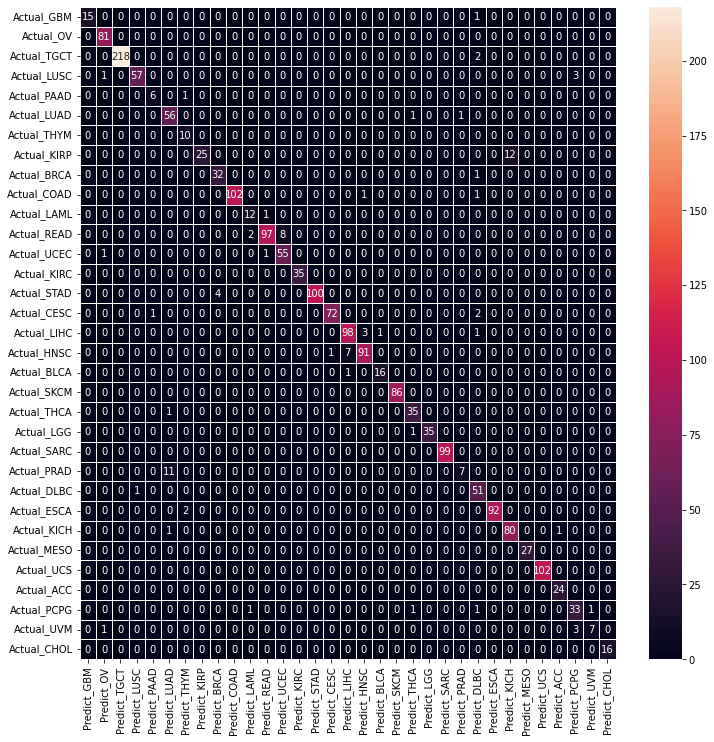

In [32]:
plot_conf_matrix(cm2,y_test_2)

In [33]:
# make predictions for test data
predictions_2 = [round(value) for value in y_pred_2]
# evaluate predictions
accuracy_2 = accuracy_score(y_test_2, predictions_2)
print("Accuracy: %.2f%%" % (accuracy_2 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_2 = precision_score(y_test_2, predictions_2, average='micro')
print('Precision for all class: %f' % precision_2)

# recall: tp / (tp + fn)
recall_2 = recall_score(y_test_2, predictions_2,average='micro')
print('Recall: %f' % recall_2)
# f1: 2 tp / (2 tp + fp + fn)
f1_2 = f1_score(y_test_2, predictions_2, average='micro')
print('F1 score: %f' % f1_2)

Accuracy: 95.66%
Precision for all class: 0.956566
Recall: 0.956566
F1 score: 0.956566


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_2.pkl' /content/gdrive/MyDrive/gene_seq/

# 3

In [34]:
test_split_3= pd.read_csv("./test_split_3.csv", sep=',')
test_split_3

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.5982,4.1277,4.1261,-6.5064,10.0168,5.6525,-0.3201,-1.1811,-1.3921,1.5950,...,2.1798,-6.5064,1.9034,2.7721,4.6077,-9.9658,8,44,1,5
1,4.6713,3.2450,3.3364,-6.5064,9.3261,5.6372,4.2736,-2.0529,1.0847,1.6558,...,2.4831,-4.0350,1.2875,2.5924,4.6826,-9.9658,8,31,0,5
2,5.7748,4.0593,3.9892,-2.7274,9.2628,4.7645,2.9966,0.6969,-1.1811,1.8363,...,1.0847,-3.6259,-0.1345,1.2636,4.1186,-9.9658,8,49,1,5
3,5.0462,2.1766,3.7836,-3.8160,9.0157,5.3972,0.3907,-0.3940,-0.7834,2.0218,...,1.6920,-2.2447,-0.4921,1.3051,4.7296,-9.9658,8,60,1,5
4,5.2502,3.0092,3.7529,-9.9658,10.4801,5.0206,-0.1031,-1.7322,-2.8262,1.5758,...,-0.2498,-4.6082,0.3115,4.1716,4.0401,-9.9658,8,22,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.6235,1.7141,5.1314,-4.0350,10.5520,4.8954,-0.8863,1.5661,-2.9324,1.7185,...,1.6420,-2.8262,0.7832,2.0638,6.1183,-9.9658,29,53,1,5
1953,4.6770,1.6093,4.5230,-5.5735,10.2727,5.1522,-2.1779,2.3251,-0.6643,1.9968,...,2.2113,-5.0116,-1.6850,1.5415,5.0299,-9.9658,29,58,0,2
1954,5.7115,1.8524,5.2246,-5.5735,10.5343,4.6566,-1.3548,1.8363,-1.1172,2.2753,...,1.9895,-2.4659,1.0222,0.1257,6.1861,-9.9658,29,47,1,5
1955,6.0157,0.5763,3.8279,-9.9658,10.7721,3.9403,-0.9686,-2.5479,-0.6643,0.7058,...,0.6880,-4.6082,-2.1140,2.6325,5.9206,-9.9658,29,3,1,2


In [35]:
test_split_3_dummies = test_split_3.copy()
test_split_3_dummies = pd.get_dummies(test_split_3_dummies)

X_test_3 = test_split_3_dummies.drop(columns_to_drop, axis=1).copy()
y_test_3 = test_split_3_dummies['cancer type abbreviation'].copy()

In [36]:
train_split_3= pd.read_csv("./train_split_3.csv", sep=',')
# train_split_1

In [37]:
train_split_3_dummies = train_split_3.copy()
train_split_3_dummies = pd.get_dummies(train_split_3_dummies)

X_train_3 = train_split_3_dummies.drop(columns_to_drop, axis=1).copy()
y_train_3 = train_split_3_dummies['cancer type abbreviation'].copy()

In [ ]:
# X_train3=X_train_3.copy()
# y_train3=y_train_3.copy()

In [ ]:
# X_train_3,X_valid_3,y_train_3 , y_valid_3  = train_test_split(X_train3,y_train3, test_size=0.2, random_state = 42, stratify=y_train_3)

In [38]:
# eval_set = [(X_train_3, y_train_3), (X_test_3, y_test_3)]

mlpc_3 = MLPClassifier(alpha=0.001,learning_rate_init=0.001 , random_state = 42,activation="relu", hidden_layer_sizes=(100,100,100),early_stopping=True,validation_fraction=0.2,solver='adam',max_iter=200, verbose=True) 
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
mlpc_3.fit(X_train_3, y_train_3)
 

Iteration 1, loss = 15.63698065


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.134100
Iteration 2, loss = 2.56011840


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.509579
Iteration 3, loss = 1.33413358


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.653895
Iteration 4, loss = 0.79930891


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.823755
Iteration 5, loss = 0.48942956


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.862069
Iteration 6, loss = 0.35033135


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.874202
Iteration 7, loss = 0.30374940


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.832056
Iteration 8, loss = 0.26424096


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.902299
Iteration 9, loss = 0.22361953


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.918263
Iteration 10, loss = 0.16371520


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.913793
Iteration 11, loss = 0.16097923


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.926564
Iteration 12, loss = 0.14065345


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.918902
Iteration 13, loss = 0.11380946


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.934227
Iteration 14, loss = 0.09750146


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.942529
Iteration 15, loss = 0.08583271


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.937420
Iteration 16, loss = 0.09776189


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938697
Iteration 17, loss = 0.07737793


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.925926
Iteration 18, loss = 0.06867322


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.901660
Iteration 19, loss = 0.09360777


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.939974
Iteration 20, loss = 0.07217889


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.921456
Iteration 21, loss = 0.06401200


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.937420
Iteration 22, loss = 0.07065969


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.918263
Iteration 23, loss = 0.05954382


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.934227
Iteration 24, loss = 0.06581389


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.925287
Iteration 25, loss = 0.04256301


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.925287
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(100, 100, 100), random_state=42,
              validation_fraction=0.2, verbose=True)

In [39]:
# Save the model as a pickle in a file
joblib.dump(mlpc_3, 'tumor_mlp_model_sort_3')
  
# Load the model from the file
mlp_model_from_joblib_3 = joblib.load('tumor_mlp_model_sort_3')

In [40]:
y_pred_3 = mlp_model_from_joblib_3.predict(X_test_3)

cm3=(confusion_matrix(y_test_3, y_pred_3))

<AxesSubplot:>

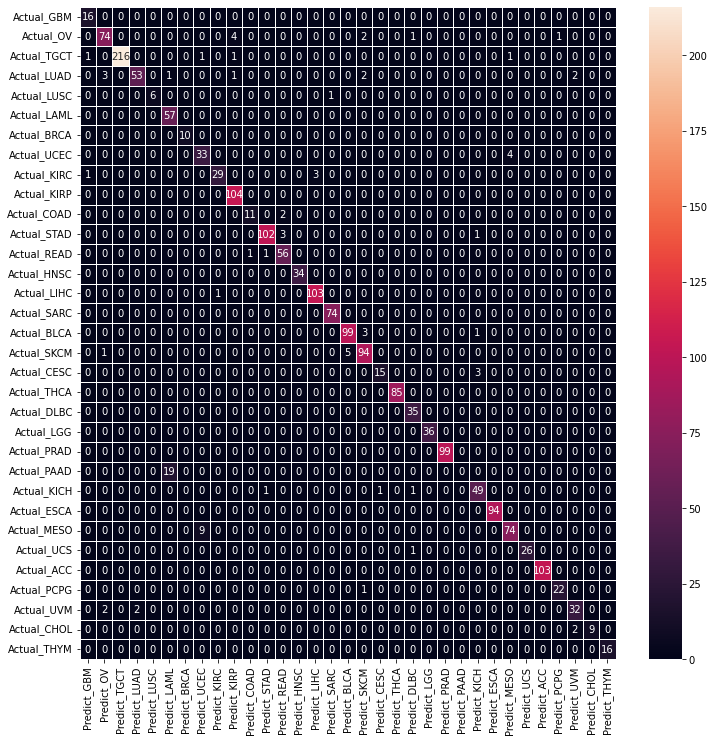

In [41]:
plot_conf_matrix(cm3,y_test_3)

In [42]:
# make predictions for test data
predictions_3 = [round(value) for value in y_pred_3]
# evaluate predictions
accuracy_3 = accuracy_score(y_test_3, predictions_3)
print("Accuracy: %.2f%%" % (accuracy_3 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_3 = precision_score(y_test_3, predictions_3, average='micro')
print('Precision for all class: %f' % precision_3)

# recall: tp / (tp + fn)
recall_3 = recall_score(y_test_3, predictions_3,average='micro')
print('Recall: %f' % recall_3)
# f1: 2 tp / (2 tp + fp + fn)
f1_3 = f1_score(y_test_3, predictions_3, average='micro')
print('F1 score: %f' % f1_3)

Accuracy: 95.35%
Precision for all class: 0.953500
Recall: 0.953500
F1 score: 0.953500


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_3.pkl' /content/gdrive/MyDrive/gene_seq/

# 4

In [43]:
test_split_4= pd.read_csv("./test_split_4.csv", sep=',')
test_split_4

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.7138,4.1178,2.9090,-1.7809,9.5309,5.4973,-1.4305,-1.7809,-0.2498,0.6425,...,2.4063,-4.0350,-2.5479,3.4635,4.3541,-9.9658,8,37,1,5
1,4.5318,2.5876,5.2642,-9.9658,9.6668,4.8580,-4.2934,-2.8262,-2.4659,2.2051,...,0.7407,-9.9658,-3.0469,0.9268,5.2499,-9.9658,8,49,0,5
2,4.8324,3.0411,3.7794,-5.5735,9.6898,5.1102,7.4223,-2.4659,1.0573,1.4228,...,2.0395,-1.3921,-1.9379,0.7579,4.7986,-9.9658,8,34,1,5
3,4.9397,2.5561,3.9459,-6.5064,9.4092,5.3958,3.4304,-0.6416,-0.4521,2.1541,...,1.4174,-9.9658,-0.2159,0.7832,4.9855,-9.9658,8,41,0,3
4,5.2502,2.3251,3.8401,-9.9658,10.0487,5.3961,0.8726,-1.7322,-0.0725,2.5338,...,1.8840,-1.2828,1.0983,2.6738,4.1820,-9.9658,8,56,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,5.4813,2.4252,5.9570,-1.6850,9.9599,4.9251,-0.9406,1.5115,-0.0425,2.2723,...,1.4808,-0.9406,1.0915,1.9931,5.9258,-9.9658,29,32,1,5
1953,4.0567,1.3679,5.4219,0.7664,9.8447,4.7677,-0.5973,3.5299,-3.4580,2.4306,...,2.5900,-4.0350,-2.8262,0.2881,4.9103,-9.9658,29,56,1,5
1954,4.6165,1.6512,5.2032,0.4125,9.9029,4.7285,1.9638,1.7446,-0.2671,1.3956,...,1.7229,-3.8160,-5.5735,-0.7346,4.9458,-9.9658,29,61,0,5
1955,5.6691,1.7660,5.2480,-4.2934,10.7449,3.9270,-0.3940,0.8568,0.6517,1.1770,...,0.8568,-3.6259,-9.9658,2.0912,5.4125,-9.9658,29,64,0,5


In [44]:
test_split_4_dummies = test_split_4.copy()
test_split_4_dummies = pd.get_dummies(test_split_4_dummies)

X_test_4 = test_split_4_dummies.drop(columns_to_drop, axis=1).copy()
y_test_4 = test_split_4_dummies['cancer type abbreviation'].copy()

In [45]:
train_split_4= pd.read_csv("./train_split_4.csv", sep=',')
# train_split_1

In [46]:
train_split_4_dummies = train_split_4.copy()
train_split_4_dummies = pd.get_dummies(train_split_4_dummies)

X_train_4 = train_split_4_dummies.drop(columns_to_drop, axis=1).copy()
y_train_4 = train_split_4_dummies['cancer type abbreviation'].copy()

In [ ]:
# X_train4=X_train_4.copy()
# y_train4=y_train_4.copy()

In [ ]:
# X_train_4,X_valid_4,y_train_4 , y_valid_4  = train_test_split(X_train4,y_train4, test_size=0.2, random_state = 42, stratify=y_train4)

In [47]:
# eval_set = [(X_train_4, y_train_4), (X_test_4, y_test_4)]

mlpc_4 = MLPClassifier(alpha=0.001,learning_rate_init=0.001 , random_state = 42,activation="relu", hidden_layer_sizes=(100,100,100),early_stopping=True,validation_fraction=0.2,solver='adam',max_iter=200, verbose=True) 
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
mlpc_4.fit(X_train_4, y_train_4)
 

Iteration 1, loss = 13.39366186


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.460409
Iteration 2, loss = 1.19565157


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.827586
Iteration 3, loss = 0.49868914


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.883780
Iteration 4, loss = 0.35202810


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.908685
Iteration 5, loss = 0.27105359


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.927842
Iteration 6, loss = 0.21623674


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.930396
Iteration 7, loss = 0.17374965


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.935504
Iteration 8, loss = 0.15709760


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.934227
Iteration 9, loss = 0.13357958


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.941890
Iteration 10, loss = 0.12068104


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938059
Iteration 11, loss = 0.10051674


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.950830
Iteration 12, loss = 0.08604145


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.933589
Iteration 13, loss = 0.07012950


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.945722
Iteration 14, loss = 0.05986250


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955939
Iteration 15, loss = 0.05866643


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.932312
Iteration 16, loss = 0.04894097


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.948276
Iteration 17, loss = 0.03912714


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955939
Iteration 18, loss = 0.03289571


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955939
Iteration 19, loss = 0.03137999


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.954023
Iteration 20, loss = 0.03087798


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.946360
Iteration 21, loss = 0.02574718


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.951469
Iteration 22, loss = 0.02051925


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959132
Iteration 23, loss = 0.02079283


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.955939
Iteration 24, loss = 0.03410689


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.947637
Iteration 25, loss = 0.02394976


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.957216
Iteration 26, loss = 0.01469228


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 27, loss = 0.01214901


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.954023
Iteration 28, loss = 0.01257644


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.958493
Iteration 29, loss = 0.00769775


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.962324
Iteration 30, loss = 0.00696134


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.960409
Iteration 31, loss = 0.00607778


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.961047
Iteration 32, loss = 0.00588405


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959132
Iteration 33, loss = 0.00551715


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.960409
Iteration 34, loss = 0.00512161


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.962963
Iteration 35, loss = 0.00489012


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.957854
Iteration 36, loss = 0.00454841


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 37, loss = 0.00429989


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.961686
Iteration 38, loss = 0.00425753


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.960409
Iteration 39, loss = 0.00396240


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.961047
Iteration 40, loss = 0.00367850


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.958493
Iteration 41, loss = 0.00370991


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 42, loss = 0.00352055


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.961047
Iteration 43, loss = 0.00322454


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 44, loss = 0.00324434


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959770
Iteration 45, loss = 0.00301430


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.962324
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(100, 100, 100), random_state=42,
              validation_fraction=0.2, verbose=True)

In [48]:
# Save the model as a pickle in a file
joblib.dump(mlpc_4, 'tumor_mlp_model_sort_4')
  
# Load the model from the file
mlp_model_from_joblib_4 = joblib.load('tumor_mlp_model_sort_4')

In [49]:
y_pred_4 = mlp_model_from_joblib_4.predict(X_test_4)

cm4=(confusion_matrix(y_test_4, y_pred_4))

In [ ]:
# def plot_conf_matrix():
#     labels=y_test_4.unique()
#     cancer_names=[]
#     for i in labels:
#         if i in cancer_name_num_dict.keys():
#             cancer_names.append(cancer_name_num_dict[i])
    
#     column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
#     indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]
    
#     table= pd.DataFrame(cm, columns=column, index=indices)
    
#     fig, ax = pyplot.subplots(figsize=(12,12))         # Sample figsize in inches

#     return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

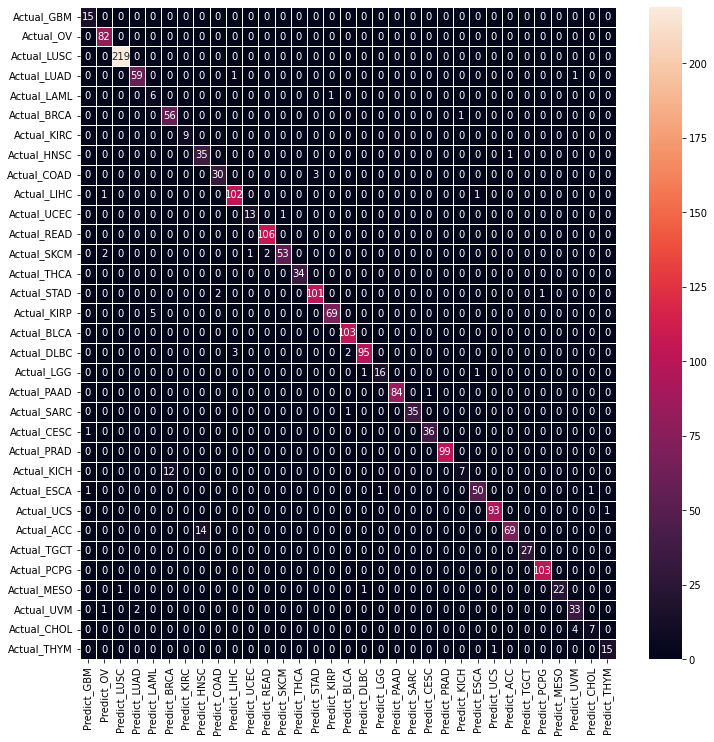

In [50]:
plot_conf_matrix(cm4,y_test_4)

In [51]:
# make predictions for test data
predictions_4 = [round(value) for value in y_pred_4]
# evaluate predictions
accuracy_4 = accuracy_score(y_test_4, predictions_4)
print("Accuracy: %.2f%%" % (accuracy_4 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_4 = precision_score(y_test_4, predictions_4, average='micro')
print('Precision for all class: %f' % precision_4)

# recall: tp / (tp + fn)
recall_4 = recall_score(y_test_4, predictions_4,average='micro')
print('Recall: %f' % recall_4)
# f1: 2 tp / (2 tp + fp + fn)
f1_4 = f1_score(y_test_4, predictions_4, average='micro')
print('F1 score: %f' % f1_4)

Accuracy: 96.22%
Precision for all class: 0.962187
Recall: 0.962187
F1 score: 0.962187


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_4.pkl' /content/gdrive/MyDrive/gene_seq/

# 5

In [52]:
test_split_5= pd.read_csv("./test_split_5.csv", sep=',')
test_split_5

,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,DACH1,FMO2,ZNF708,...,KIF16B,CYP4F2,TENM1,BATF3,PPP6R1,OR8D4,cancer type abbreviation,age_at_initial_pathologic_diagnosis,gender,race
0,4.6759,2.4960,3.4609,-4.6082,9.7135,5.7955,1.3109,1.0293,-3.0469,1.3567,...,1.9490,-3.0469,-3.0469,1.7273,4.9691,-9.9658,8,63,0,5
1,5.8829,3.0252,3.3119,-6.5064,9.4547,5.4900,1.4174,-1.4305,-1.8836,1.8801,...,1.4011,-5.0116,-0.3383,3.7561,5.0184,-9.9658,8,55,0,5
2,5.8199,2.8076,3.9031,-6.5064,9.2346,5.6787,0.6425,-0.3383,-2.3147,3.0110,...,1.4120,-4.6082,2.2330,4.2111,5.2877,-9.9658,8,31,1,2
3,5.3162,4.2758,3.4437,-5.5735,9.8965,5.6303,0.4447,-1.0559,-0.4921,1.9564,...,1.8363,-5.0116,-5.5735,3.4411,5.1148,-9.9658,8,58,1,5
4,5.1339,2.9186,3.5299,-3.6259,9.6870,5.7436,3.0446,1.7446,-0.4131,2.0638,...,1.5013,-3.4580,1.1184,1.9377,4.1555,-9.9658,8,57,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,3.3535,-0.2159,3.1095,-9.9658,9.4021,4.2743,-5.5735,-4.2934,-1.7322,-0.2159,...,0.8647,6.3266,-0.6416,-0.2159,3.3307,-9.9658,15,50,1,5
1952,3.5262,0.6699,2.4359,-9.9658,8.7991,3.8330,-3.3076,-2.9324,0.1257,-1.8314,...,2.0183,5.8352,-2.2447,-0.5332,3.4384,-9.9658,15,41,1,5
1953,6.0219,-0.1665,2.6962,-4.0350,12.3251,3.7720,-0.9971,-1.5105,-1.9379,-0.9686,...,-1.5522,-2.4659,-0.4921,2.9729,6.6918,-9.9658,29,59,0,5
1954,5.0631,2.9784,3.5212,-5.5735,9.6838,5.0466,1.3956,-2.1140,-1.4699,0.3231,...,1.4704,-0.1031,-5.5735,2.4386,4.8530,-9.9658,4,38,1,5


In [53]:
test_split_5_dummies = test_split_5.copy()
test_split_5_dummies = pd.get_dummies(test_split_5_dummies)

X_test_5 = test_split_5_dummies.drop(columns_to_drop, axis=1).copy()
y_test_5 = test_split_5_dummies['cancer type abbreviation'].copy()

In [54]:
train_split_5= pd.read_csv("./train_split_5.csv", sep=',')
# train_split_1

In [55]:
train_split_5_dummies = train_split_5.copy()
train_split_5_dummies = pd.get_dummies(train_split_5_dummies)

X_train_5 = train_split_5_dummies.drop(columns_to_drop, axis=1).copy()
y_train_5 = train_split_5_dummies['cancer type abbreviation'].copy()

In [ ]:
# X_train5=X_train_5.copy()
# y_train5=y_train_5.copy()

In [ ]:
# X_train_5,X_valid_5,y_train_5 , y_valid_5  = train_test_split(X_train5,y_train5, test_size=0.2, random_state = 42, stratify=y_train5)

In [56]:
# eval_set = [(X_train_5, y_train_5), (X_test_5, y_test_5)]

mlpc_5 = MLPClassifier(alpha=0.001,learning_rate_init=0.001 , random_state = 42,activation="relu", hidden_layer_sizes=(100,100,100),early_stopping=True,validation_fraction=0.2,solver='adam',max_iter=200, verbose=True) 
# xgb_model= GridSearchCV(estimator=xgb_Classifier, param_grid=grid, cv= 5)
mlpc_5.fit(X_train_5, y_train_5)
 

Iteration 1, loss = 12.10038796


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.583653
Iteration 2, loss = 1.17042611


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.826948
Iteration 3, loss = 0.58067794


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.886973
Iteration 4, loss = 0.35964545


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.915070
Iteration 5, loss = 0.24639378


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.937420
Iteration 6, loss = 0.20091349


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.922733
Iteration 7, loss = 0.16981881


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.940613
Iteration 8, loss = 0.13273268


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.950830
Iteration 9, loss = 0.11316047


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.926564
Iteration 10, loss = 0.11188750


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.934227
Iteration 11, loss = 0.10193662


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.928480
Iteration 12, loss = 0.09277835


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938059
Iteration 13, loss = 0.07920341


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.950830
Iteration 14, loss = 0.06507991


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.950830
Iteration 15, loss = 0.04534375


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.951469
Iteration 16, loss = 0.05052988


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943806
Iteration 17, loss = 0.05112013


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.943806
Iteration 18, loss = 0.03814338


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.942529
Iteration 19, loss = 0.03426145


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.944444
Iteration 20, loss = 0.02532310


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.957854
Iteration 21, loss = 0.01911983


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.956577
Iteration 22, loss = 0.01962031


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.957216
Iteration 23, loss = 0.01440260


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.952746
Iteration 24, loss = 0.01225829


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.953384
Iteration 25, loss = 0.01094611


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959132
Iteration 26, loss = 0.00940238


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959132
Iteration 27, loss = 0.00738720


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.959132
Iteration 28, loss = 0.00724309


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.957216
Iteration 29, loss = 0.00653349


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.957854
Iteration 30, loss = 0.00907667


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.945722
Iteration 31, loss = 0.03076253


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.953384
Iteration 32, loss = 0.02275896


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.938697
Iteration 33, loss = 0.02732587


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.914432
Iteration 34, loss = 2.62248099


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.658365
Iteration 35, loss = 0.63787963


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.909962
Iteration 36, loss = 0.17406120


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


Validation score: 0.918263
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(100, 100, 100), random_state=42,
              validation_fraction=0.2, verbose=True)

In [57]:
# Save the model as a pickle in a file
joblib.dump(mlpc_5, 'tumor_mlp_model_sort_5')
  
# Load the model from the file
mlp_model_from_joblib_5 = joblib.load('tumor_mlp_model_sort_5')

In [58]:
y_pred_5 = mlp_model_from_joblib_5.predict(X_test_5)

cm5=(confusion_matrix(y_test_5, y_pred_5))

<AxesSubplot:>

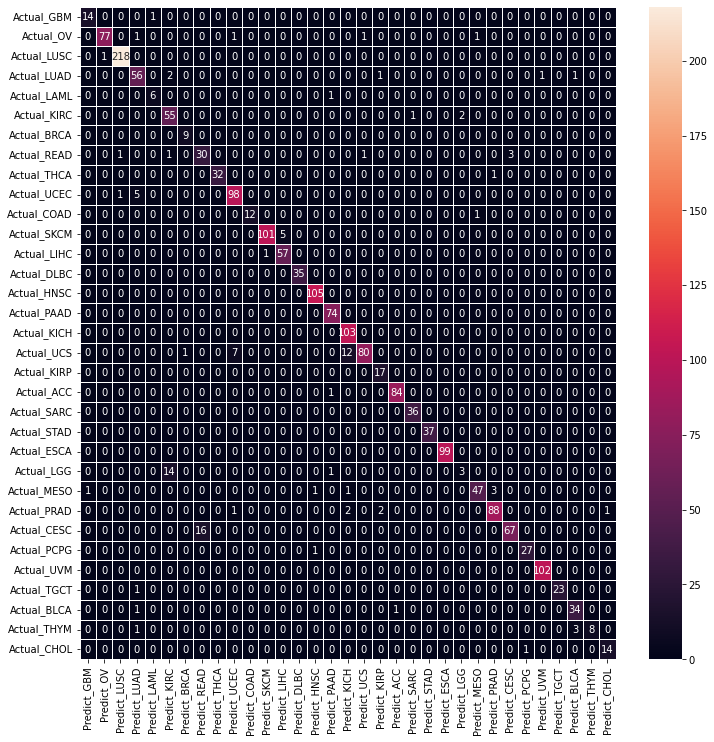

In [59]:
plot_conf_matrix(cm5, y_test_5)

In [61]:
# make predictions for test data
predictions_5 = [round(value) for value in y_pred_5]
# evaluate predictions
accuracy_5 = accuracy_score(y_test_5, predictions_5)
print("Accuracy: %.2f%%" % (accuracy_5 * 100.0))

# precision tp / (tp + fp)
# precision = precision_score(y_test, predictions, average=None)
# print('Precision for every class: %f' % precision.astype(str))
precision_5 = precision_score(y_test_5, predictions_5, average='micro')
print('Precision for all class: %f' % precision_5)

# recall: tp / (tp + fn)
recall_5 = recall_score(y_test_5, predictions_5,average='micro')
print('Recall: %f' % recall_5)
# f1: 2 tp / (2 tp + fp + fn)
f1_5 = f1_score(y_test_5, predictions_5, average='micro')
print('F1 score: %f' % f1_5)

Accuracy: 94.48%
Precision for all class: 0.944785
Recall: 0.944785
F1 score: 0.944785


In [ ]:
# !cp -r '/content/tumor_xgb_model_sort_5.pkl' /content/gdrive/MyDrive/gene_seq/

# avg accuracy

In [62]:
avg_acc=(accuracy_1+accuracy_2+accuracy_3+accuracy_4+accuracy_5)/5
avg_acc

0.9533924154599973

In [63]:
cm=cm1+cm2+cm3+cm4+cm5

In [64]:
def plot_final_conf_matrix():
    labels=y_test_1.unique()
    cancer_names=[]
    for i in labels:
        if i in cancer_name_num_dict.keys():
            cancer_names.append(cancer_name_num_dict[i])
    
    column= [f'Predict_{cancer_name}' for cancer_name in cancer_names]
    indices= [f'Actual_{cancer_name}' for cancer_name in cancer_names]
    
    table= pd.DataFrame(cm, columns=column, index=indices)
    
    fig, ax = pyplot.subplots(figsize=(20,20))         # Sample figsize in inches

    return sn.heatmap(table, annot=True, fmt="d",  linewidths=.5, ax=ax)

<AxesSubplot:>

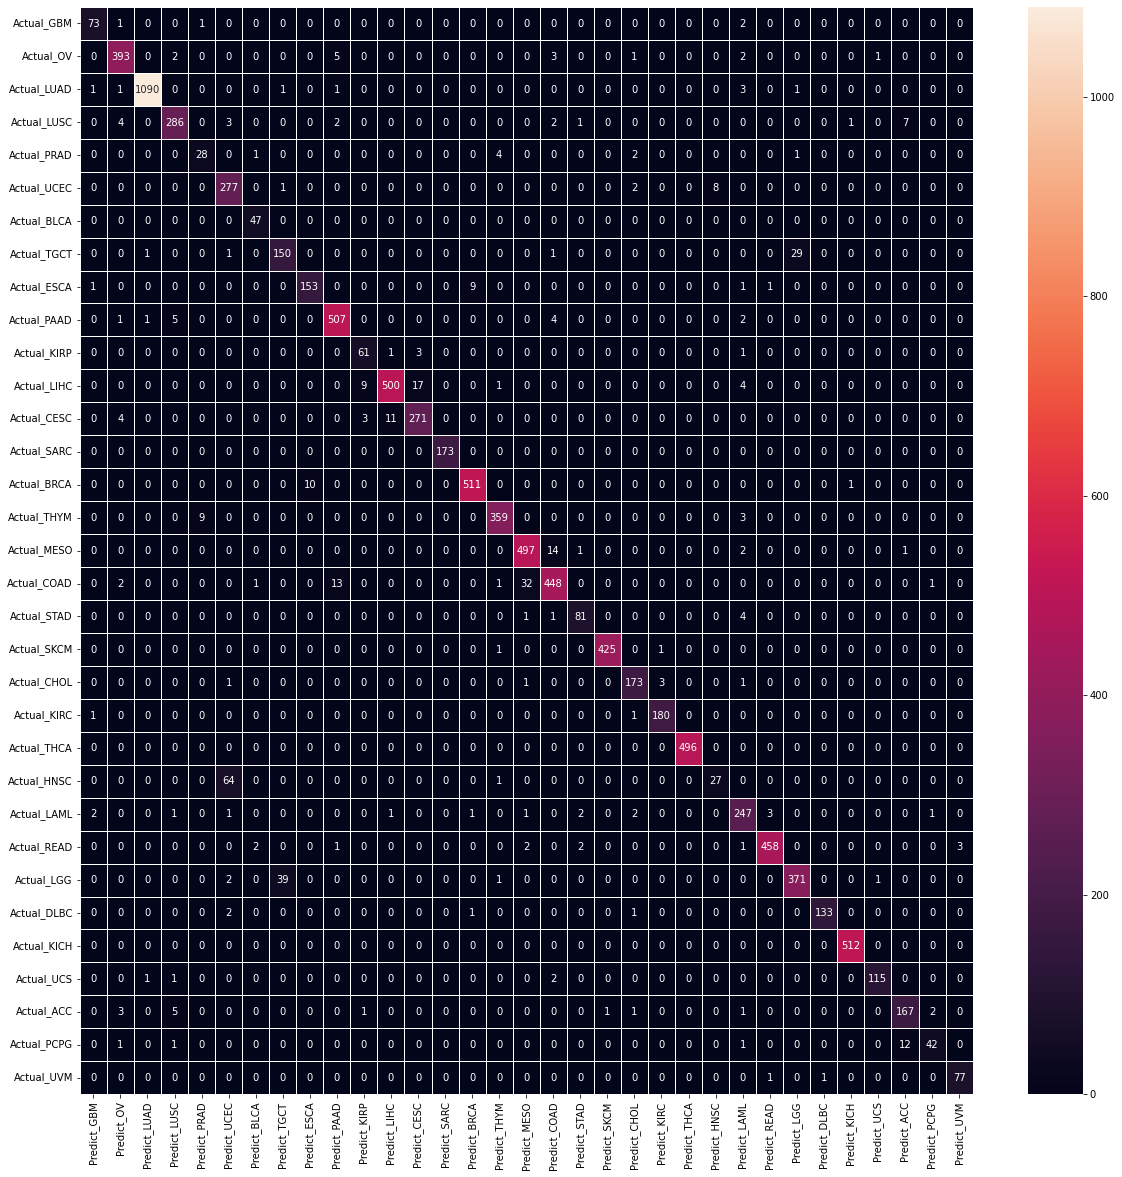

In [65]:
plot_final_conf_matrix()